In [1]:
import geopandas as gpd # Geospatial data operations
import pandas as pd # Tabular data operations
from glob import glob # Finding files
import os
import matplotlib # Plotting
import contextily as cx # Basemaps
import osmnx as ox
matplotlib.rcParams['figure.figsize'] = (20, 10)
files = glob("Onehunga_POI0322/*.shp")
files

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


['Onehunga_POI0322/onehunga_park.shp',
 'Onehunga_POI0322/onehunga_medical_point.shp',
 'Onehunga_POI0322/onehunga_supm_conve.shp',
 'Onehunga_POI0322/onehunga_rest_cafe.shp',
 'Onehunga_POI0322/onehunga_busstop_point.shp',
 'Onehunga_POI0322/onehunga_school.shp']

In [2]:
dfs = []
for f in files:
    # Read in each shapefile
    df = gpd.read_file(f)
    # Record the category based on the filename
    df["category"] = os.path.splitext(os.path.basename(f))[0].replace("onehunga_", "")
    dfs.append(df)

# Reproject to NZGD2000 (EPSG:2193), so units are in meters, not degrees
df = pd.concat(dfs).to_crs(2193)
df

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,...,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTY,STOPLAT,STOPLON,PARENTSTAT,MODE
0,0.0,-36.928792,174.784494,Gloucester Park,ChIJP2senE1PDW0R9c-WycX1xlQ,POINT (1758932.401 5911539.652),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,-36.922669,174.800483,Captain Springs Reserve,ChIJ9a8JjstIDW0RHfIbxw4LzxM,POINT (1760369.380 5912192.154),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,-36.911138,174.800399,Oranga Plunket Clinic,ChIJRdAHp8ZIDW0RvEv6agNJR4E,POINT (1760386.025 5913471.627),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,-36.924106,174.789916,Rowe Reserve East,ChIJ-frCEAJJDW0RM_Urv0pjHvE,POINT (1759425.142 5912050.503),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,-36.920526,174.792803,Buch Park,ChIJhYjfdLZIDW0RdOS3nEfuzbg,POINT (1759689.719 5912442.763),park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,32.0,-36.918464,174.775892,Robert Howell Teacher Of Singing Piano And Violin,ChIJ8zT2DKlIDW0RqZ5MGkB41io,POINT (1758187.572 5912699.763),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,33.0,-36.920439,174.800548,Youth Skills Nz Ltd,ChIJhxXXvM5IDW0RGPqkwj4Zc_A,POINT (1760379.860 5912439.432),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,36.0,-36.909680,174.780656,Alexander Technique Auckland - Jann McMichael,ChIJW_dPiKNIDW0RAWDnHQc12Fs,POINT (1758630.188 5913666.441),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,37.0,-36.918265,174.770806,Onehunga High School English Language School,ChIJaY-HRQJGDW0RQO2XIwz5phQ,POINT (1757734.906 5912730.267),school,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


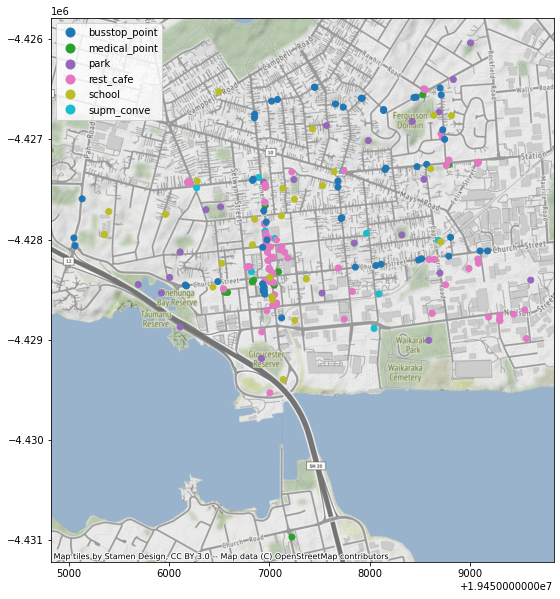

In [3]:
ax = df.to_crs(epsg=3857).plot(column='category', categorical=True, legend=True)
cx.add_basemap(ax)

In [4]:
# Take a sample
sample = df.sample(1)
sample

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,...,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTY,STOPLAT,STOPLON,PARENTSTAT,MODE
61,102.0,-36.920165,174.78512,Gratitude Restro Bar,ChIJgZybznBJDW0RzvWL077lXkE,POINT (1759006.079 5912495.675),rest_cafe,103.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
indexes = []
for c in df.category.unique():
    if c != sample.category.iloc[0]:
        distances = df[df.category == c].distance(sample.geometry.iloc[0])
        index = distances.idxmin()
        distance = distances[index]
        print(f"nearest {c}: {distance:.1f} meters")
        indexes.append(index)
indexes

nearest park: 445.5 meters
nearest medical_point: 246.9 meters
nearest supm_conve: 49.4 meters
nearest busstop_point: 19.1 meters
nearest school: 138.7 meters


[5, 10, 1, 45, 8]